# Vision Transformer

This is mostly a verbose re-implementation of [this repo](https://github.com/lucidrains/vit-pytorch) so that I can picture how the forward pass works in my head.

In [2]:
import torch
import torch.nn as nn
from torchprofile import profile_macs

torch.manual_seed(1);

### Step 1: Flatten the input image into a vectors of patches

In [3]:
channels = 3
image_size = 224
patch_size = 32

x = torch.rand((1,channels,image_size,image_size))

num_patches = (image_size // patch_size) ** 2
patch_dim = channels * patch_size ** 2

input_size = x.size()

x = x.reshape((1,num_patches,patch_dim))

print(f"{input_size} => {x.size()}")

torch.Size([1, 3, 224, 224]) => torch.Size([1, 49, 3072])


### Step 2: Linear Projection

In [4]:
dim = 128
linear_projection = nn.Linear(patch_dim, dim)

x = linear_projection(x)
x.size()

torch.Size([1, 49, 128])

### Step 3: Add class token

In [5]:
# if batch size is greater than one then you need a repeat in here
class_tokens = nn.Parameter(torch.randn(1, 1, dim))

x = torch.cat((class_tokens, x), dim=1)
x.size()

torch.Size([1, 50, 128])

### Step 4: Add positional encoding

In [6]:
# + 1 because we have the class tokens
pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, dim))
pos_embedding.size()

torch.Size([1, 50, 128])

In [7]:
x += pos_embedding
x.size()

torch.Size([1, 50, 128])

### Step 5: Pass through the Transformer encoder

The Transformer is comprised of $L$ layers of multi-headed self attention followed by an MLP. 

The attention module looks like this:
1. Using a linear layer, project the input patches ($50 \times 128$) into $Q,K,V$ matrices each of size $128 \times D$ where $D$ is a dim of our choice (in the paper it's 64).
2. Compute the scaled dot product of $Q$ and $K^\top$, scaled by the dimension $D$.
3. Softmax (2) and multiply by $V$

In the Multi-headed Self Attention (MSA) module there are $H$ heads, which we downscale via another matrix $W_o$.

I struggled to picture the sizes of these so I drew a picture:

![](attention.png)

Here's how we implement MSA and the MLP:

In [8]:
class MSA(nn.Module):
    def __init__(self, n_heads=8, d_k=64, dim=128, layers=12):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_k
        
        self.projection = nn.Linear(dim, 3*d_k*n_heads)
        self.downscale = nn.Linear(d_k*n_heads, dim)
        
    def forward(self, x):
        b = x.size()[0] # get batch size
        
        # project x into Q, K, V matrices
        W = self.projection(x).chunk(3, dim=-1)
        
        # reshape into matrices of size (n_heads, patches, d_k)
        Q,K,V = map(lambda t: t.reshape((b, self.n_heads, -1, self.d_k)), W)
        
        # get the number of patches
        _, _, p, _ = K.size()
        
        # do the attention equation
        zs = torch.matmul(torch.softmax((Q @ K.permute((0,1,3,2))) / 
                                            self.d_k**-0.5, dim=-1), V)
        
        # concatenate the outputs of each head 
        zs = zs.reshape(b, p, (self.n_heads*self.d_k))
        
        # project through the downscaling layer 
        return self.downscale(zs)
    
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)

To collate this into a transformer we need a few more bits and bobs (these are lifted directly from [here](https://github.com/lucidrains/vit-pytorch).

In [9]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
    
class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth=12, heads=8, dim_head=64, mlp_dim=128):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, MSA(n_heads = heads, d_k=dim_head))),
                Residual(PreNorm(dim, MLP(dim, mlp_dim)))
            ]))
            
    def forward(self, x, mask = None):
        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)
        return x

transformer = TransformerEncoder(dim=128)

out = transformer(x)
out.size()

torch.Size([1, 50, 128])

### Step 5: Extract class prediction from attention

Via a small MLP:

In [10]:
dim = 128
num_classes = 10

# just get the class token
out = out[:, 0]

mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes))

mlp_head(out)

tensor([[-0.1783, -0.3554,  0.6473, -0.5952, -0.3453,  0.5627,  0.1692,  0.3190,
          0.6042, -0.3114]], grad_fn=<AddmmBackward>)

## Putting it all together

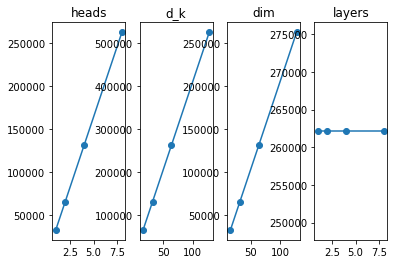

In [20]:
import matplotlib.pyplot as plt

msa = MSA(n_heads=8, d_k=64, dim=128, layers=12)

heads = [1,2,4,8]
d_k   = [16,32,64,128]
dim   = [16,32,64,128]
layers =[1,2,4,8]

things_to_scale = {
    'heads': heads,
    'd_k' : d_k,
    'dim' : dim,
    'layers': layers,
}

fig, axs = plt.subplots(1,4 )

axs = axs.ravel()

inputs = torch.randn((1, 50, 128))

def profile_macs(msa, inps):
    params, ops = 0, 0
    
    params += torch.numel(msa.projection.weight)
    params += torch.numel(msa.downscale.weight) 
    
    return params
    
for ax, thing_to_scale in zip(axs, things_to_scale.keys()):
    
    ax.set_title(thing_to_scale)
    
    opts = things_to_scale[thing_to_scale]
    
    if thing_to_scale == 'heads':
        y = []
        for opt in opts:
            msa = MSA(n_heads=opt)
            macs = profile_macs(msa, inputs)
            y.append(macs)
        
        ax.plot(opts, y, marker='o')
    elif thing_to_scale == 'd_k':
        y = []
        for opt in opts:
            msa = MSA(d_k=opt)
            macs = profile_macs(msa, inputs)
            y.append(macs)
        
        ax.plot(opts, y, marker='o')
    elif thing_to_scale == 'dim':
        y = []
        for opt in opts:
            msa = MSA(dim=opt)
            macs = profile_macs(msa, inputs)
            y.append(macs)
        
        ax.plot(opts, y, marker='o')
    else:
        y = []
        for opt in opts:
            msa = MSA(layers=opt)
            macs = profile_macs(msa, inputs)
            y.append(macs)
        
        ax.plot(opts, y, marker='o')
